In [50]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, mannwhitneyu, norm

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

import seaborn as sns
from matplotlib import pyplot as plt

In [13]:
groups = pd.read_csv('groups.csv', sep = ';')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep = ';')

    groups.csv : файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
    active_studs.csv : файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
    checks.csv : файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [14]:
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


In [9]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
groups.shape[0],active_studs.shape[0],checks.shape[0]

(74576, 8341, 541)

In [19]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [20]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [22]:
groups.rename(columns={"id": "student_id"}, inplace=True)

    В датафрейме active_studs находятся студенты, которые заходили в приложение во время эксперимента;
    В датафрейме groups находятся студенты, которые были распределены на тестовую и контрольную группы во время эксперимента;
    В датафрейме active_studs находятся студенты, которые оплатили что-то во время эксперимента в приложение.

In [23]:
groups.merge(active_studs)

,student_id,grp
0,946259,B
1,1896859,B
2,938570,A
3,4808409,B
4,3242161,B
...,...,...
8336,1524221,B
8337,1302888,A
8338,1778339,B
8339,1138474,A


In [24]:
active_studs.merge(checks)

,student_id,rev
0,1184303,1530.0000
1,3354191,1900.0001
2,3278734,1900.0000
3,720651,1980.0000
4,1232221,1900.0000
...,...,...
387,3890326,199.0000
388,1390994,398.0000
389,1516339,290.0000
390,3910596,597.0000


    Cтрок стало явно меньше и причин здесь может быть несколько:

    У пользователей, которые не были занесены ни в какую группу, были списаны деньги за подписку на нашем сервисе;
    У пользователей, которые не были занесены ни в какую группу, были списаны деньги за услуги, оплата произошла позже.

In [25]:
real_students = active_studs.merge(checks)
real_students = real_students.merge(groups)
real_students.head()

,student_id,rev,grp
0,1184303,1530.0000,A
1,3354191,1900.0001,B
2,3278734,1900.0000,B
3,720651,1980.0000,A
4,1232221,1900.0000,B


In [29]:
real_students.query("grp == 'A'").shape[0]

78

In [28]:
real_students.query("grp == 'B'").shape[0]

314

In [30]:
(78 / 314) * 100

24.840764331210192

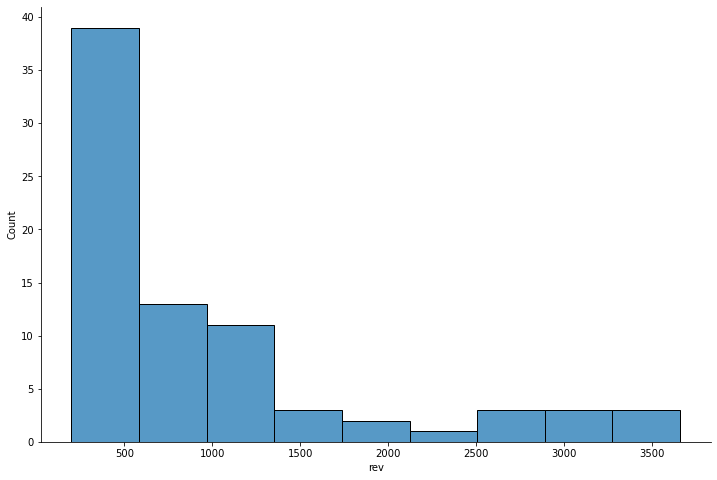

In [52]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query("grp == 'A'").rev)
sns.despine()

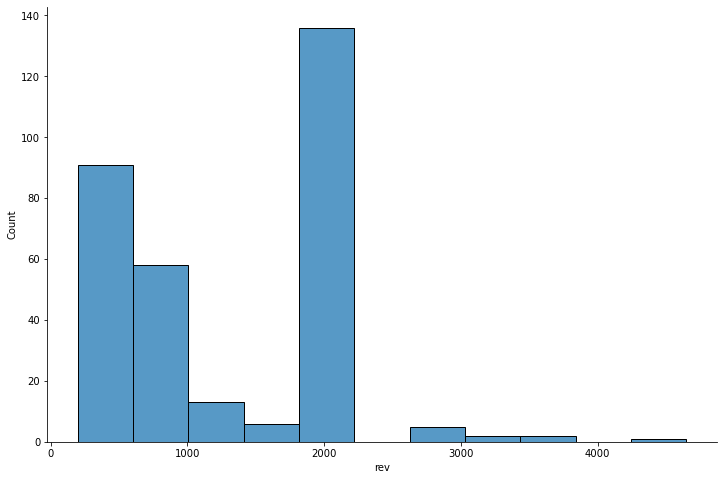

In [53]:
plt.figure(figsize=(12, 8))
sns.histplot(real_students.query("grp == 'B'").rev)
sns.despine()

In [38]:
print(shapiro(real_students.query("grp == 'A'").rev), shapiro(real_students.query("grp == 'B'").rev), sep="\n")

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


И по графикам и при помощи теста можно подтвердить, что распределения явно ненормальные.

In [39]:
a_group = real_students.query("grp == 'A'")
b_group = real_students.query("grp == 'B'")

In [40]:
mannwhitneyu(a_group.rev, b_group.rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Разница все таки есть, а теперь проверим гипотезу о медианном значении в чеке в разных группах и таким образом H0 - медианное значения в группах равны:

In [41]:
print(a_group.rev.median(), b_group.rev.median(), sep="\n")

585.0
1140.0


In [47]:
a_group_rev = np.array(a_group.rev)
b_group_rev = np.array(b_group.rev)

In [48]:
print(bs.bootstrap_ab(a_group_rev, b_group_rev, bs_stats.median, bs_compare.percent_change))

-48.68421052631579    (-64.47368421052632, -25.5)


Доверительный интервал не захватывает 0 и поэтому можно считать, что следует отклонить H0

   ## ВЫВОД
    В ходе эксперимента было выявлено, что разница в группах на основе ниже приведенных выводов:

    Разницу между распределениями в 2 группах есть, что показал первый анализ;
    Разницу медианных значений в двух группах есть и в тестовой группе это значение больше, что показал 2 анализ.
    На основе исследований, я бы ввел в наше приложение фичу, которая была в тестовой группе.
